In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import rasterio
from skimage import measure, feature, morphology
import matplotlib.pyplot as plt
import m2py.segmentation.segmentation_gmm as seg_gmm
import m2py.segmentation.segmentation_watershed as seg_water
from m2py.utils import pre_processing as pre
from m2py.utils import post_processing as post
from m2py.utils import seg_label_utils as slu
from m2py.utils import config
from scipy import stats
from PIL import Image

from time import time
import json
from collections import defaultdict
from functools import lru_cache
from tqdm.notebook import tqdm

## Unsupervised segmentation

In [27]:
data_dir = os.path.join(os.getcwd(), "../sam_data/images/raw_images")
label_dir = os.path.join(os.getcwd(), "../sam_data/annotations")

clean_data_dir = os.path.join(os.getcwd(), "../sam_data/images/clean_images")
mask_dir = os.path.join(os.getcwd(), "../sam_data/masks/unsupervised_masks")

train_data_dir = os.path.join(os.getcwd(), "../sam_data/images/train_images")
train_mask_dir = os.path.join(os.getcwd(), "../sam_data/masks/train_masks")


In [28]:
# Plotting hyper-parameters
fill_zeros_flag = True
input_cmap = "jet"

def plot_image(data, title="", colorbar=False):
    plt.figure(figsize=(10,8))
    plt.title(title)
    plt.imshow(data, "gist_ncar")
    if colorbar:
        plt.colorbar()
    plt.show()
    
def get_pixel_coords(mask):
    row_inds, col_inds = np.where(mask)
    left = min(col_inds)
    right = max(col_inds) + 1
    top = min(row_inds)
    bottom = max(row_inds) + 1
    width = abs(right - left)
    height = abs(top - bottom)
    return left, right, top, bottom, width, height
    
def remove_white_frames(data, to_plot=False):
    
    # Plot raw image
    if to_plot:
        plot_image(data, f)
    
    # Find valid columns after removing empty frames
    cols_data = np.median(data, axis=(0,2))
    median_col = np.median(cols_data)
    low_c = 0
    for i, c in enumerate(cols_data):
        if c < 230: # remove white frames
            low_c = i
            break
                  
    # Find valid rows after removing empty frames
    rows_data = np.median(data, axis=(1,2))
    median_row = np.median(rows_data)
            
    high_r = 0
    for i, r in enumerate(rows_data[::-1]):
        if r < 240: # remove white frames
            high_r = i
            break 
            
    # Keep only valid rows and columns after removing empty frames
    data = data[:-1-high_r, low_c:, :] # -1 to remove backwards

    # Plot image without frames
    if to_plot:
        plot_image(data, f)

    return data

def extract_resolution_info(data, to_plot=False):
    # Extract resolution information within image from bottom right corner
    
    resolution_info = {}
    height, width, channels = data.shape
    
    # Gather outlines from bottom right corner
    res_size = 500 # defines size of bottom right corner
    res_data = np.mean(data[-res_size:,-res_size:,:], axis=2) # get gray image
    res_value = (res_data < 10).astype(np.uint8) # get outlines
    
    # Removes common FP outline detections
    res_value[:res_size//3,:] = 0
    res_value[:,:res_size//3] = 0
    res_value[:res_size//2,:res_size//2] = 0

    # Gathers outline components (bars, x-res, and y-res)
    res_comps = measure.label(res_value, connectivity=2)
    res_comps = morphology.remove_small_objects(res_comps, 50)
    
    # Plot (bars, x, and y resolution)
    if to_plot:
        plot_image(res_comps, title=f, colorbar=True)

    # Extract resolution from bars
    unique_comps = list(np.unique(res_comps))
    unique_comps.remove(0) # remove background component
    biggest_comp = max(unique_comps, key = lambda k: np.sum(res_comps==k)) # largest component (i.e., bars)
    
    biggest = res_comps == biggest_comp
    bars_left, bars_right, bars_top, bars_bottom, bars_width, bars_height = get_pixel_coords(biggest)
    if bars_height / bars_width > 0.9: # Enforces that bars have same dimensions
        bars_width = bars_height

    resolution_info["num_pixels_x_bar"] = float(bars_width)
    resolution_info["num_pixels_y_bar"] = float(bars_height)
        
    # Removes resolution bars from input image
    data = data[:,:width-res_size+bars_left,:]
    
    # Plot cleaned-up image
    if to_plot:
        plot_image(data, title=f)
        
    unique_comps.remove(biggest_comp) # remove bars (largest) component
    unique_comps = sorted(unique_comps, key=lambda k: min(np.where(res_comps==k)[1])) # sort from left to right
    
    extracted_resolutions = [] # x_res, y_res due to sorting from left to right
    for c_i in unique_comps:
        
        # Get coordinates from resolution box
        i_left, i_right, i_top, i_bottom, i_width, i_height = get_pixel_coords(res_comps == c_i)
        i_top += 1 # to remove frame
        i_bottom -= 1 # to remove frame
        i_left += 1 # to remove frame
        i_right -= 1 # to remove frame
        
        # Get data inside resolution box
        res_value_temp = (res_data < 100).astype(np.uint8)
        i_data = res_value_temp[i_top:i_bottom,i_left:i_right]
        i_data =  morphology.binary_dilation(i_data, morphology.square(2))
        
        if i_height > i_width: # deal with vertical numbers
            i_data = np.rot90(i_data)

        # Plot resolution bounding box
        #plot_image(i_data, title=f)

        # Gather resolution-number components
        num_comps = measure.label(i_data, connectivity=1)
        unique_num_comps = list(np.unique(num_comps))
        unique_num_comps.remove(0) # remove background component
        
        sorted_comps = sorted(unique_num_comps, key=lambda k: min(np.where(num_comps==k)[1])) # sort from left to right
        unique_num_comps = sorted_comps[:-2] # remove last two components (micro meters)
        
        # Perform rule-based OCR
        final_num = ""
        for n in unique_num_comps:    
            n_left, n_right, n_top, n_bottom, n_width, n_height = get_pixel_coords(num_comps == n)
            n_data = i_data[n_top:n_bottom, n_left:n_right]        
            
            # Plot number image
            #plot_image(n_data)
            
            if n_data[:,n_width//2-1:].sum() / n_data.sum() > 0.75: # right biased means 1
                final_num += "1"
                continue
                
            no_border_num = n_data[2:-2, 2:-2]
            no_border_num_temp = n_data[3:-3, 2:-2]
            if no_border_num_temp.sum() == 0: # empty means 0 after removing frame
                final_num += "0"
                continue
                
            row_nonum_inds, col_nonum_inds = np.where(no_border_num)
            unique_rows = set(row_nonum_inds)
            if all(r < 3 for r in unique_rows): # top biased means 5 after removing frame
                final_num += "5"
                continue
                
            if all(r >= 2 for r in unique_rows): # bottom biased means 2 after removing frame
                final_num += "2"
                continue
                
            print("ERROR: Failed to extract number.")
        
        if to_plot:
            print(f"Extracted number is {final_num}")
        
        extracted_resolutions.append(int(final_num))
        
    resolution_info["res_x_bar"] = float(extracted_resolutions[0])
    resolution_info["res_y_bar"] = float(extracted_resolutions[1])
    return resolution_info, data

def print_resolution_info(res_info, data, to_print=True):
    
    height, width, channels = data.shape

    data_properties = config.data_info[data_type]['properties']
    if to_print:
        print(f"Shape of input data is: {data.shape}")
        print(f"Properties are: {data_properties}")
        
        print(f"Number of pixels making up y-resolution bar: {res_info['num_pixels_y_bar']}")
        print(f"Number of pixels making up x-resolution bar: {res_info['num_pixels_x_bar']}")
    
    height_meters = height / res_info['num_pixels_y_bar'] * res_info["res_y_bar"]
    width_meters = width / res_info['num_pixels_x_bar'] * res_info["res_x_bar"]
    res_info["height_meters"] = float(height_meters)
    res_info["width_meters"] = float(width_meters)
    
    if to_print:
        print(f"Height of sample is {round(height_meters, 1)} micro meters")
        print(f"Width of sample is {round(width_meters, 1)} micro meters")
    
    res_y_pixel = height_meters / height
    res_x_pixel = width_meters / width
    res_info["res_y_pixel"] = float(res_y_pixel)
    res_info["res_x_pixel"] = float(res_x_pixel)
    
    if to_print:
        print(f"y-resolution per pixel is {round(res_y_pixel, 2)} micro meters")
        print(f"x-resolution per pixel is {round(res_x_pixel, 2)} micro meters")
    
    return res_info
    
def apply_segmentation(data, to_plot=False):
    
    height, width, channels = data.shape
    value = np.mean(data, axis=2)
    
    # Get local outliers
    detections1 = pre.extract_outliers_from_all_properties(data, data_type, 2.5, 256, 256, max_iterations=3)
    
    # Get global outliers
    detections2 = pre.extract_outliers_from_all_properties(data, data_type, 2.5, max_iterations=3) 
    detections = np.logical_or(detections1, detections2) # combine outliers    
    
    # Plot outlier detections
    if to_plot:
        plot_image(detections)
        
    # Clean up results using morphological operations
    detections = morphology.remove_small_objects(detections.astype(bool), 100)
    detections = morphology.binary_closing(detections, morphology.disk(10))
    detections = morphology.binary_opening(detections, morphology.disk(2))
    detections = morphology.remove_small_objects(detections, 300)
    detections = morphology.binary_closing(detections, morphology.disk(20))
    detections = morphology.binary_dilation(detections, morphology.disk(2)) # needed for fibres to not be broken
    detections = morphology.binary_opening(detections, morphology.disk(5))
    detections = morphology.binary_erosion(detections, morphology.disk(2))

    # Gather components from outlier detections
    comps = measure.label(detections, connectivity=2)
    unique_comps = list(np.unique(comps))
    unique_comps.remove(0)
    
    # Plot detections after morphological clean-up
    if to_plot:
        plot_image(comps, colorbar=True)

    # Get minimum distance from component to center of image
    center = np.array([height//2, width//2]).reshape(2,1)
    cen = lambda k: np.min(np.linalg.norm(np.vstack(np.where(comps==k)) - center, axis=0, ord=1))
    
    # Distance from center of image to bottom right corner
    max_distance = np.linalg.norm(center - np.array([[height], [width]]), ord=1)
    
    # Exclude components that are too near the border of the image
    remove_list = []
    for c in unique_comps:
        row_inds, col_inds = np.where(comps == c)
        c_mean = np.mean(col_inds)
        r_mean = np.mean(row_inds)
        if c_mean < 75 or c_mean > width - 75 or r_mean < 75 or r_mean > height - 75: # using actual distance to bdry
            remove_list.append(c)
            continue

        if cen(c) / max_distance >= 0.4: # using normalized distance to bdry
            remove_list.append(c)
            continue
            
    for c in remove_list:
        unique_comps.remove(c)
    
    if len(unique_comps) == 0:
        return False, None
    
    # Plot all components after central removal
    if to_plot:
        plot_image(np.isin(comps, unique_comps))
    
    # Select component of interest
    big = lru_cache(maxsize=10)(lambda k: np.sum(comps==k))    
    std = lru_cache(maxsize=10)(lambda k: np.std(np.abs(value[comps==k] - np.median(value)) / np.std(value)))
    comb = lru_cache(maxsize=10)(lambda k: (big(k)) * (std(k) > 0.35) * (std(k) ** 0.5))
    
    biggest_comps = sorted(unique_comps, key = big, reverse=False)[-3:]
    
    # Plot all large components
    if to_plot:
        plot_image(np.isin(comps, biggest_comps))
    
    # The dataset contains several fibres; this checks first if any detection is a fibre.
    std_comp = None
    for c in biggest_comps[::-1]:
        row_inds, col_inds = np.where(comps == c)
        l, r = np.min(col_inds), np.max(col_inds)
        t, b = np.min(row_inds), np.max(row_inds)
        
        comp_area = len(row_inds)
        occ_area = (r - l) * (b - t)
        if round(comp_area / occ_area, 1) < 0.3: # if a fibre, don't use combined score
            std_comp = c
            break
    
    if std_comp is None: # if not a fibre, use the combined score
        std_comp = max(biggest_comps, key = comb)

    # Selects output component
    out = comps == std_comp
    
    # Remove FP pixels of selected component. Threshold is 75th percentile of component.
    out2 = (np.abs(value * out - np.median(value)) / np.std(value) > 
            0.25 * np.percentile(np.abs(value[out] - np.median(value)) / np.std(value), 75))
    out2 *= out
    
    out2 = morphology.binary_closing(out2, morphology.disk(1))
    
    # Select largest component after FP removal
    comps = measure.label(out2, connectivity=2)
    unique_comps = list(np.unique(comps))
    unique_comps.remove(0)
    
    biggest_comp = sorted(unique_comps, key = lambda k: np.sum(comps==k))[-1]

    out = comps == biggest_comp

    # Fill up gaps and holes of selected component
    out = morphology.binary_closing(out.astype(bool), morphology.disk(20))
    out = morphology.remove_small_holes(out, 5000)

    if to_plot:
        plt.figure(figsize=(16,4))
        plt.subplot(1,3,1)
        plt.imshow(data)

        plt.subplot(1,3,2)
        plt.imshow(out)

        plt.subplot(1,3,3)
        plt.imshow(data)
        d = np.ma.masked_where(out == 0, out)
        plt.imshow(d, alpha=0.5, cmap="gist_ncar")

        plt.tight_layout()
        plt.show()

    return True, out
    

In [ ]:
# Don't run this cell. It's used to visualize masks of all samples

files = os.listdir(data_dir)
for indice, f in enumerate(files[0:]):
    
    if any(t in f for t in ["rtf", "DS", "xlsx", "docx"]):
        continue
        
    if os.path.isdir(os.path.join(data_dir, f)):
        continue
        
    print(f"Id {indice}, Image {f} -----------------")
        
    data_file = os.path.join(data_dir, f)
    data_type = "Raman"

    data = rasterio.open(data_file).read()
    data = np.moveaxis(data, source=0, destination=-1)
    data = data[...,:3]
    
    data = remove_white_frames(data, to_plot=True)
                    
    res_info, data = extract_resolution_info(data, to_plot=True)
    res_info = print_resolution_info(res_info, data, to_print=True)

    did_pass, out = apply_segmentation(data, to_plot=True)

In [32]:
# Store mask and resolution info per image

out_json_path = os.path.join(label_dir, "resolution_info.json")
if os.path.exists(out_json_path):
    with open(out_json_path, "r") as infl:
        res_dict = json.load(infl)
else:
    res_dict = defaultdict(dict)
    
files = os.listdir(data_dir)
pbar = tqdm(files)
for f in pbar:
    pbar.set_description(f)
    if any(t in f for t in ["rtf", "DS", "xlsx", "docx"]):
        continue
        
    if os.path.isdir(os.path.join(data_dir, f)):
        continue
                
    out_image_path = os.path.join(clean_data_dir, f.replace(".bmp", ".png"))
    out_mask_path = os.path.join(mask_dir, f.replace(".bmp", ".png"))
    
    out_train_image_path = os.path.join(train_data_dir, f.replace(".bmp", ".npy"))
    out_train_mask_path = os.path.join(train_mask_dir, f.replace(".bmp", ".npy"))
                    
    key = f.replace(".bmp", "")
    if os.path.exists(out_train_mask_path) and os.path.exists(out_train_image_path) and key in res_dict:
        continue
        
    data_file = os.path.join(data_dir, f)
    data_type = "Raman"

    data = rasterio.open(data_file).read()
    data = np.moveaxis(data, source=0, destination=-1)
    data = data[...,:3]
    
    data = remove_white_frames(data, to_plot=False)
               
    res_info, data = extract_resolution_info(data, to_plot=False)
    res_info = print_resolution_info(res_info, data, to_print=False)
    
    if key not in res_dict:
        res_dict[key] = res_info

    did_pass, out = apply_segmentation(data, to_plot=False)
    
    if not did_pass:
        continue
    
    # Save images and masks
    if not os.path.exists(out_image_path):
        im = Image.fromarray(data)
        im.save(out_image_path)
    
    if not os.path.exists(out_mask_path):
        im = Image.fromarray(out)
        im.save(out_mask_path)
    
    if not os.path.exists(out_train_mask_path):
        resized_out = np.array(Image.fromarray(out).resize((256, 256)))
        with open(out_train_mask_path, "wb") as outfl:
            np.save(outfl, resized_out)
        
    if not os.path.exists(out_train_image_path):
        resized_data = np.array(Image.fromarray(data).resize((256, 256)))
        with open(out_train_image_path, "wb") as outfl:
            np.save(outfl, resized_data)
        
with open(out_json_path, "w") as outfl:
    json.dump(res_dict, outfl)
    

  0%|          | 0/576 [00:00<?, ?it/s]

## Compute features for decision tree

In [79]:

# Load text annotations
labels_file = os.path.join(label_dir, "version_2_corrected.xlsx")
with open(labels_file, "rb") as infl:
    labels_df = pd.read_excel(infl, header=0, index_col=0, usecols=["Sample", "Description", "Binary ID"])
    temp_dict = labels_df.to_dict(orient="dict")
    labels_dict = temp_dict ["Description"]
    labels_dict_binary = temp_dict["Binary ID"]

# Clean up text annotations
for k, v in labels_dict.items():
    v = v.split(",")[0].strip()
    if len(v.split(" ")) == 1:
        labels_dict[k] = v
    else:
        v = v.split(" ")[-1]
        
        if v in ["sphere", "circle", "sphereoid"]:
            v = "spheroid"
            
        if v == "fragment":
            v = "shard"
            
        labels_dict[k] = v
    
class_labels = list(set(l for l in labels_dict.values()))
print(f"Class labels: {class_labels}")
    
# Load up resolution info
json_path = os.path.join(label_dir, "resolution_info.json")
with open(json_path, "r") as infl:
    res_dict = json.load(infl)

print(f"Total number of images found {len(res_dict)}")
    
# extent = fill_area / bbox area (how much the shape covers its bounding box) [unitless]
# eccentricity = minor axis / major axis (how circular a shape is; good for spheres) [unitless]
# compactness = perimeter ^ 2 / fill_area (measures how elongated shapes are; good for fibres) [unitless]
# solidity = fill_area / convel hull area (good to distinguish shard and irregular) [unitless]
metrics = ["eccentricity", "perimeter", "area", "convex_area", "bbox_area", "filled_area", "minor_axis_length", "major_axis_length"]
    
data = defaultdict(dict)
files = os.listdir(mask_dir)
c = 0
for f in tqdm(files):
    if any(t in f for t in ["DS"]):
        continue
            
    image_name = f.replace(".png", "")
            
    mask_file = os.path.join(mask_dir, f)
    mask = np.array(Image.open(mask_file))
    h, w = mask.shape
    
    mask_res = res_dict[image_name]

    mask = mask.astype(np.int)
    mask_metrics = measure.regionprops_table(mask, properties=metrics)
    mask_metrics["compactness"] = 4 * np.pi * mask_metrics["area"] / mask_metrics["perimeter"] ** 2
    mask_metrics["extent"] = mask_metrics["area"] / mask_metrics["bbox_area"]
    mask_metrics["solidity"] = mask_metrics["area"] / mask_metrics["convex_area"]
    
    # Convert to micro meters and micro meters square
    mask_metrics["area"] = mask_metrics["area"] * (mask_res["height_meters"] * mask_res["width_meters"])/ (h * w)  
    mask_metrics["perimeter"] *= (mask_res["res_x_pixel"] + mask_res["res_y_pixel"]) / 2
    
    image_name_clean = image_name.split(" - ")[0]
    clas = labels_dict.get(image_name_clean, None)
    if clas is None:
        c += 1
        continue
        
    binary_clas = labels_dict_binary.get(image_name_clean)
        
    data[image_name].update(mask_metrics)
    data[image_name]["class"] = clas
    data[image_name]["binary_class"] = binary_clas
    data[image_name]["source"] = image_name
    
data = [data[i] for i in data]

print(f"No class label found for {c} images")
print(f"Number of training data {len(data)}")



Class labels: ['shard', 'irregular', 'spheroid', 'fiber']
Total number of images found 575


  0%|          | 0/569 [00:00<?, ?it/s]

No class label found for 143 images
Number of training data 425


In [80]:
# Set up data for decision tree

n = len(data)
X = np.zeros((n, 4))
Y = []
Y_binary = []
for i, values in enumerate(data):
    Y.append(values["class"]) # TODO phase (class) or binary classification (binary_class)
    X[i] = [values["eccentricity"], values["compactness"], values["extent"], values["solidity"]]
    
    

In [81]:
# Ranges of properties used for classification
print(class_labels)
print(np.min(X,axis=0))
print(np.max(X,axis=0))


['shard', 'irregular', 'spheroid', 'fiber']
[0.1955838  0.0370998  0.04110513 0.14549124]
[0.99861487 0.8863513  0.83514493 0.99016867]


## Cross-Validation for Decision Tree

In [89]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

n_splits = 5
kf = KFold(n_splits=n_splits) # n_splits = 5 is similar to 20% save for testing
kf.get_n_splits(X)

f1_average = 0
for train_index, test_index in kf.split(X):
    
    X_train, X_test = X[train_index], X[test_index]
    Y_train = [Y[i] for i in train_index]
    Y_test = [Y[i] for i in test_index]
    
    dtc = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=3, max_depth=3)
    dtc.fit(X_train, Y_train)
    Z_test = dtc.predict(X_test)
    Z_train = dtc.predict(X_train)  

    print("Test metrics:")
    print(confusion_matrix(Y_test, Z_test, dtc.classes_))
    print(classification_report(Y_test, Z_test, dtc.classes_))
    cr = classification_report(Y_test, Z_test, dtc.classes_, output_dict=True)
    f1_average += cr["macro avg"]["f1-score"]
          
print(f"Weighted F1 score across {n_splits} is {f1_average / n_splits}")

Test metrics:
[[21  5  0  0]
 [ 1  9  3  0]
 [ 4 10 18  0]
 [ 0  3  5  6]]
              precision    recall  f1-score   support

       fiber       0.81      0.81      0.81        26
   irregular       0.33      0.69      0.45        13
       shard       0.69      0.56      0.62        32
    spheroid       1.00      0.43      0.60        14

    accuracy                           0.64        85
   macro avg       0.71      0.62      0.62        85
weighted avg       0.72      0.64      0.65        85

Test metrics:
[[26  0  2  0]
 [ 6  8  5  0]
 [ 1  4 18  0]
 [ 0  5  5  5]]
              precision    recall  f1-score   support

       fiber       0.79      0.93      0.85        28
   irregular       0.47      0.42      0.44        19
       shard       0.60      0.78      0.68        23
    spheroid       1.00      0.33      0.50        15

    accuracy                           0.67        85
   macro avg       0.71      0.62      0.62        85
weighted avg       0.70      0.67  

/Users/diegotorrejon/Projects/Other/fantastic-microplastic-machine/VENV/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['fiber' 'irregular' 'shard' 'spheroid'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/Users/diegotorrejon/Projects/Other/fantastic-microplastic-machine/VENV/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['fiber' 'irregular' 'shard' 'spheroid'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/Users/diegotorrejon/Projects/Other/fantastic-microplastic-machine/VENV/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['fiber' 'irregular' 'shard' 'spheroid'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional a

## Train decision tree

In [83]:
# Train test split

from sklearn.model_selection import train_test_split

state = 0
split = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=state, test_size=split)
indices_train, indices_test, _, _ = train_test_split(np.arange(0, n), Y, random_state=state, test_size=split)

for c in np.unique(Y_train):
    print(f"Class label: {c}")
    print(f"Test size is: {Y_test.count(c)}")
    print(f"Train size is: {Y_train.count(c)}")
    print("--------")


Class label: fiber
Test size is: 29
Train size is: 110
--------
Class label: irregular
Test size is: 15
Train size is: 48
--------
Class label: shard
Test size is: 26
Train size is: 131
--------
Class label: spheroid
Test size is: 15
Train size is: 51
--------


In [84]:
# Train decision tree

dtc = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=3, max_depth=3)
dtc.fit(X_train, Y_train)
Z_test = dtc.predict(X_test)
Z_train = dtc.predict(X_train)


## Explore decision tree results

In [85]:
# Score report

print(f"Classes: {dtc.classes_}")
print("---------------")

print("Train metrics:")
print(confusion_matrix(Y_train, Z_train, dtc.classes_))
print(classification_report(Y_train, Z_train, dtc.classes_))
print("---------------")

print("Test metrics:")
print(confusion_matrix(Y_test, Z_test, dtc.classes_))
print(classification_report(Y_test, Z_test, dtc.classes_))


Classes: ['fiber' 'irregular' 'shard' 'spheroid']
---------------
Train metrics:
[[103   7   0   0]
 [  6  34   8   0]
 [  6  23 100   2]
 [  0  10  21  20]]
              precision    recall  f1-score   support

       fiber       0.90      0.94      0.92       110
   irregular       0.46      0.71      0.56        48
       shard       0.78      0.76      0.77       131
    spheroid       0.91      0.39      0.55        51

    accuracy                           0.76       340
   macro avg       0.76      0.70      0.70       340
weighted avg       0.79      0.76      0.75       340

---------------
Test metrics:
[[26  1  0  2]
 [ 5  7  3  0]
 [ 2  5 18  1]
 [ 0  5  8  2]]
              precision    recall  f1-score   support

       fiber       0.79      0.90      0.84        29
   irregular       0.39      0.47      0.42        15
       shard       0.62      0.69      0.65        26
    spheroid       0.40      0.13      0.20        15

    accuracy                           0.62 

/Users/diegotorrejon/Projects/Other/fantastic-microplastic-machine/VENV/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['fiber' 'irregular' 'shard' 'spheroid'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/Users/diegotorrejon/Projects/Other/fantastic-microplastic-machine/VENV/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['fiber' 'irregular' 'shard' 'spheroid'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/Users/diegotorrejon/Projects/Other/fantastic-microplastic-machine/VENV/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['fiber' 'irregular' 'shard' 'spheroid'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional a

In [77]:
def explore_results(X, Y, Z, indices, alike=False):

    condition = np.where(Y == Z)[0] if alike else np.where(Y != Z)[0] 
    for ii in condition:

        i = indices[ii]

        f = data[i]["source"] + ".bmp"
        data_file = os.path.join(data_dir, f)

        image = rasterio.open(data_file).read()
        image = np.moveaxis(image, source=0, destination=-1)
        image = image[...,:3]

        print(f)
        #print(f"True label: {data[i]['class']}")
        print(["eccentricity", "compactness", "extent", "solidity"])
        print(X[ii]) 
        print(f"True label: {Y[ii]}")
        print(f"Prediction: {Z[ii]}")

        mask_file = os.path.join(mask_dir, f.replace(".bmp", ".png"))
        out = np.array(Image.open(mask_file))

        plt.figure(figsize=(12,8))
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(out, cmap="gist_ncar")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


In [ ]:
explore_results(X_train, Y_train, Z_train, indices_train)



/Users/diegotorrejon/Projects/Other/fantastic-microplastic-machine/VENV/lib/python3.6/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


20200818 74_1 - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.51237316 0.74315656 0.68566828 0.94995166]
True label: spheroid
Prediction: shard


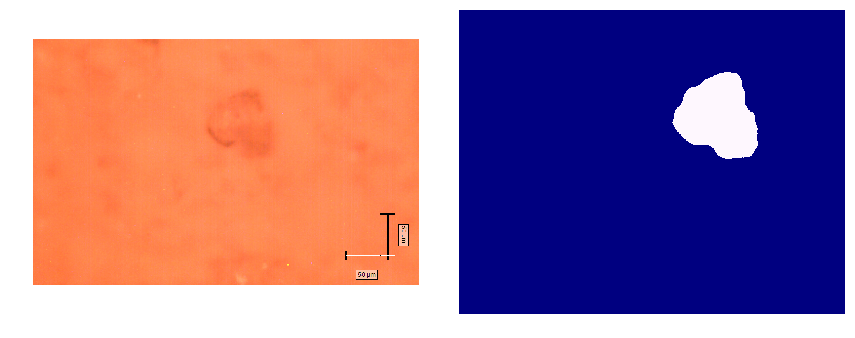

20200817 73_1 - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.90151513 0.34412541 0.50820391 0.63950535]
True label: spheroid
Prediction: irregular


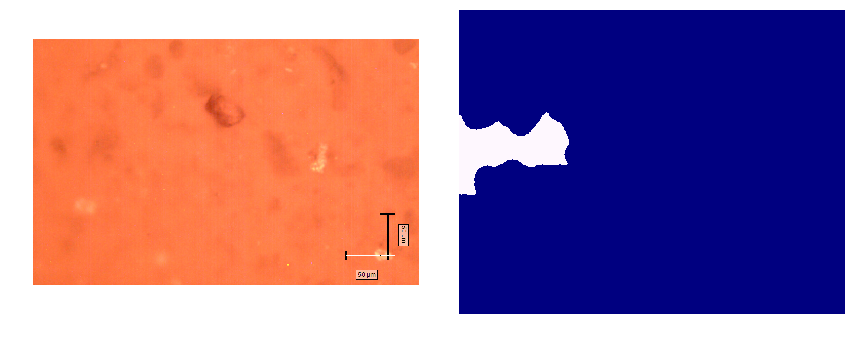

20190110 Oakland Oyster 4g.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.90413306 0.32621148 0.3520062  0.6045273 ]
True label: fiber
Prediction: irregular


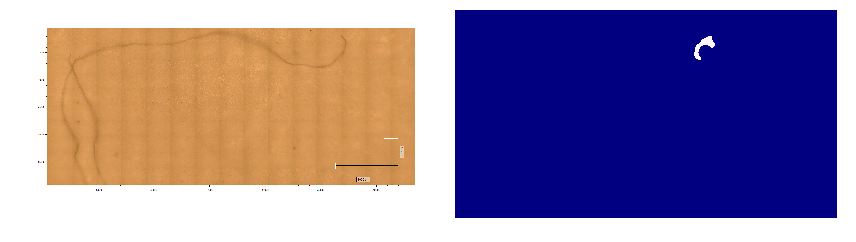

20210611 55.6 - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.76103779 0.63411401 0.73573184 0.91735718]
True label: irregular
Prediction: shard


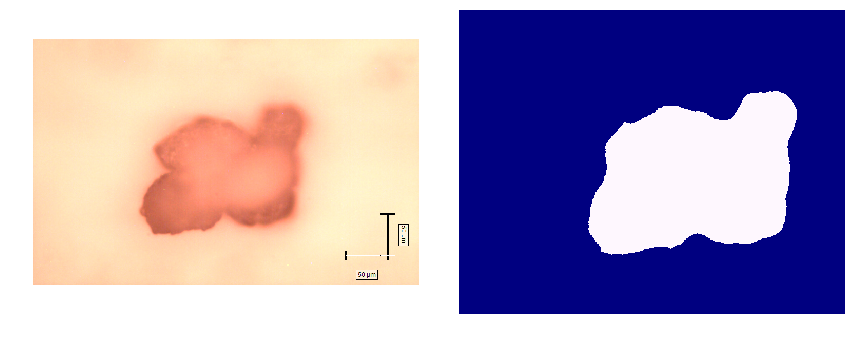

20200124 Set2Sample6_3 - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.33437381 0.82515853 0.67148554 0.95430393]
True label: fiber
Prediction: spheroid


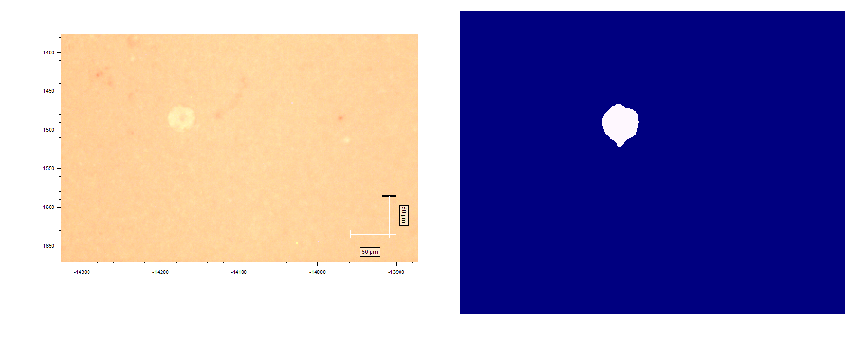

20190111 Kopachuck Oyster 3a - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.95955812 0.29842416 0.52981916 0.70826047]
True label: irregular
Prediction: fiber


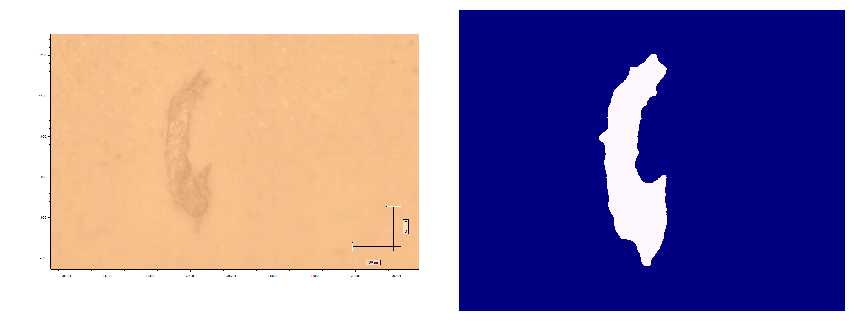

20210422 49.5 - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.54883646 0.24066371 0.55843983 0.6922823 ]
True label: spheroid
Prediction: irregular


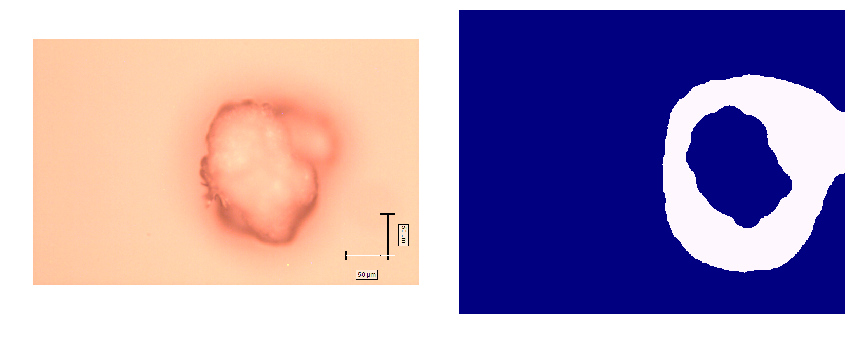

20200124 Set2Sample6_4 - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.53103198 0.79789645 0.77166401 0.95745383]
True label: spheroid
Prediction: shard


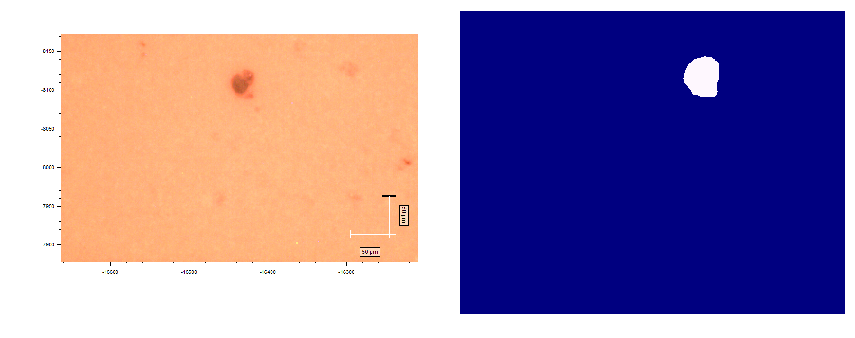

20210225 35.3 - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.42529686 0.12024757 0.40086518 0.52688936]
True label: shard
Prediction: irregular


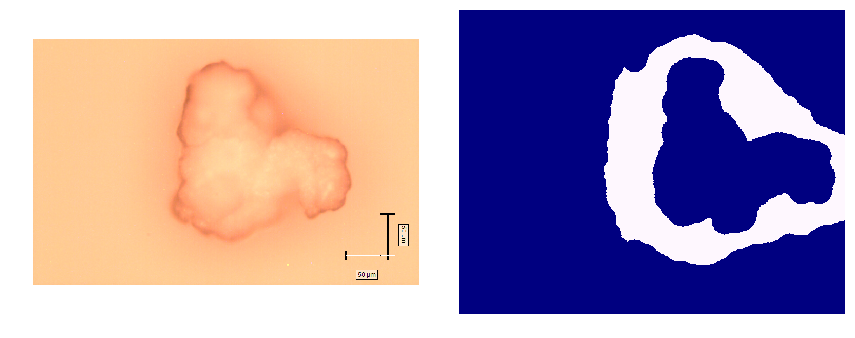

20190113 Penrose Pt Oyster 11c - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.88729348 0.44985208 0.5323301  0.79234104]
True label: spheroid
Prediction: shard


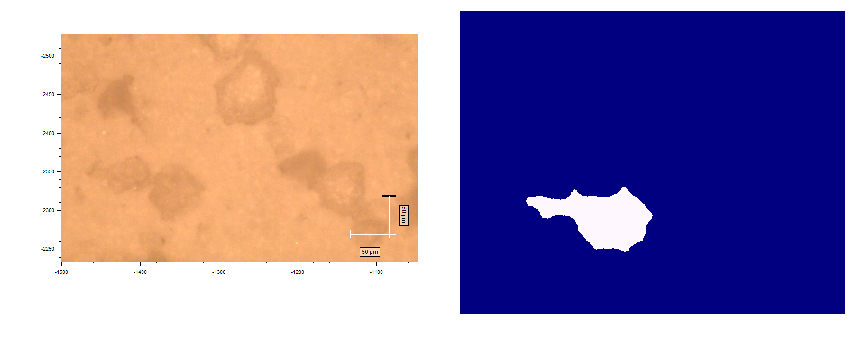

20191004 Set3Sample3_4 - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.9240455  0.59101799 0.60040431 0.87524558]
True label: spheroid
Prediction: shard


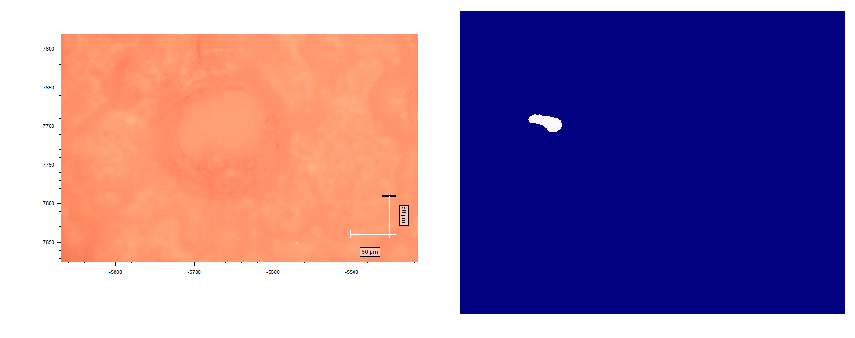

20200124 Set2Sample6_2 - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.45826146 0.76816607 0.63006397 0.92691343]
True label: spheroid
Prediction: shard


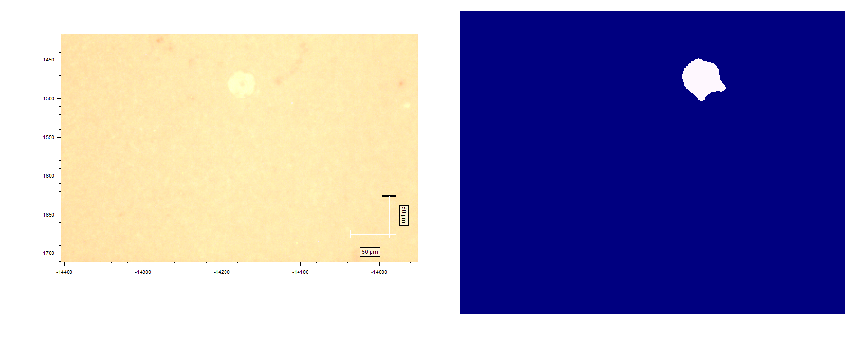

20201223 35.2 - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.74406172 0.17828382 0.37808716 0.45681435]
True label: shard
Prediction: irregular


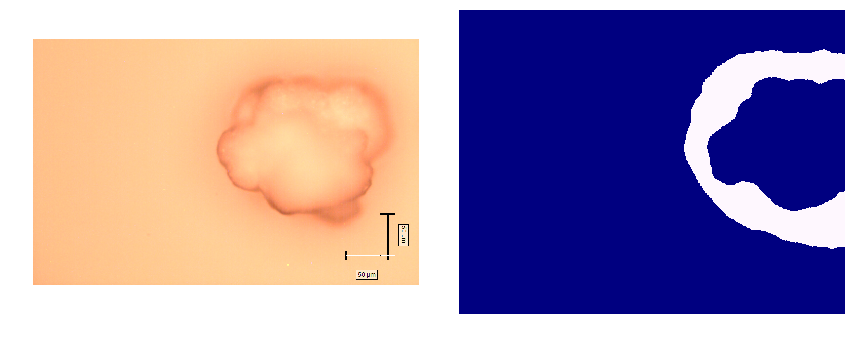

20201223 20.2 - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.41760911 0.81172868 0.74474137 0.97435013]
True label: shard
Prediction: spheroid


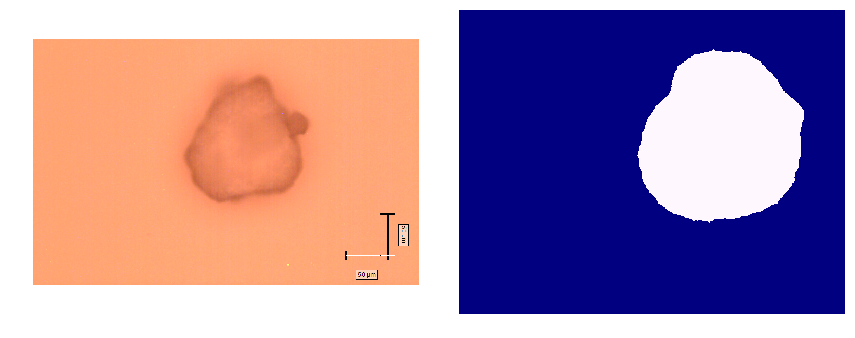

20200124 Set2Sample6_5 - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.47124326 0.86354877 0.73369565 0.93967517]
True label: fiber
Prediction: spheroid


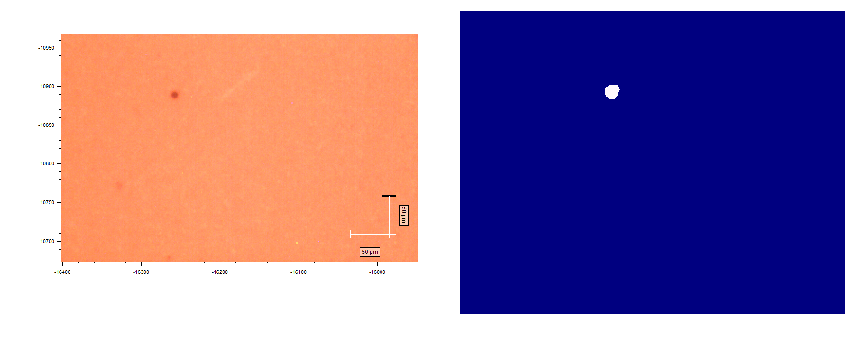

20190110 Oakland Control 1-3a.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.962463   0.33472996 0.50990619 0.70649094]
True label: irregular
Prediction: fiber


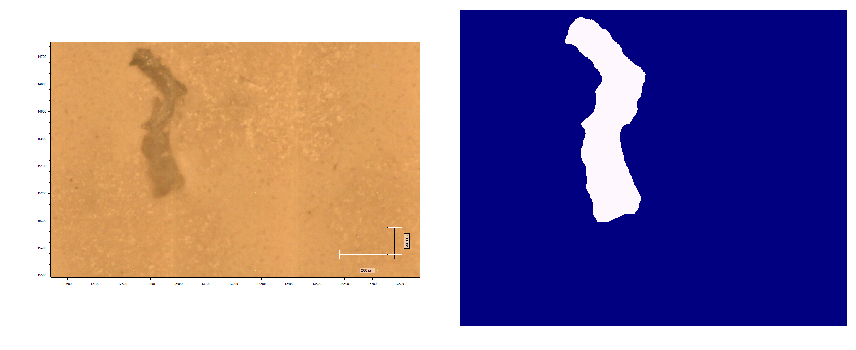

20190114 NBay Oyster 12f - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.66079357 0.76766641 0.67678503 0.93449321]
True label: spheroid
Prediction: shard


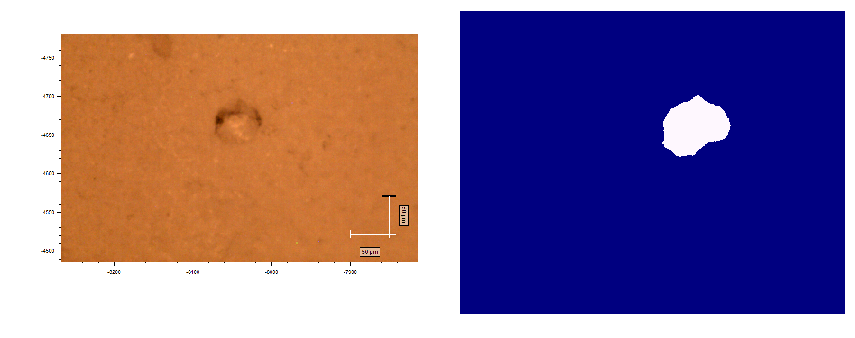

20210225 21.3 - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.73176169 0.27618418 0.57762613 0.78815088]
True label: irregular
Prediction: shard


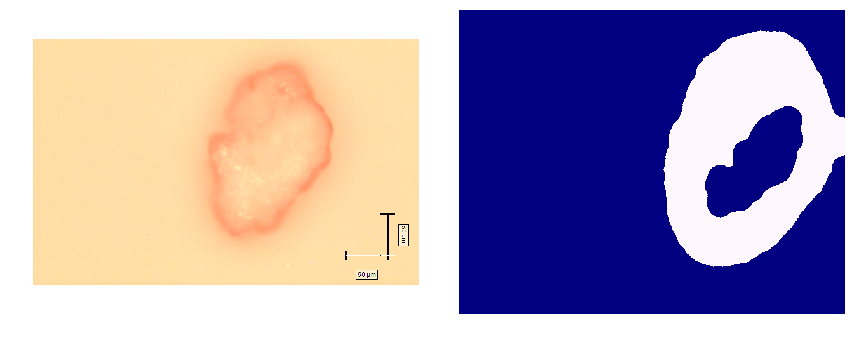

20210225 7.3 - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.28712293 0.34027796 0.63939168 0.81447587]
True label: spheroid
Prediction: shard


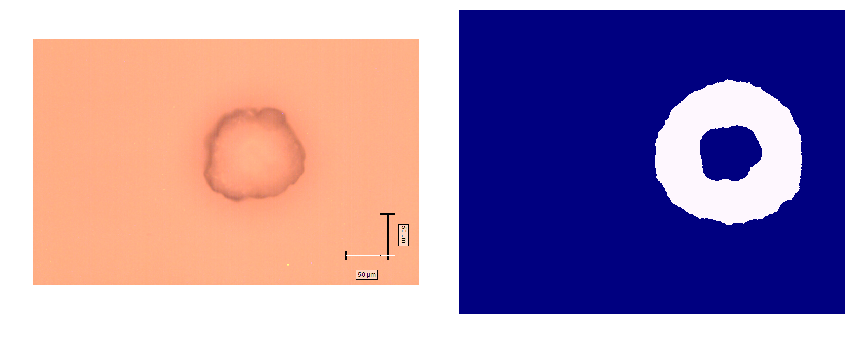

20201223 14.2 - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.75811106 0.09577384 0.30665437 0.43829441]
True label: shard
Prediction: irregular


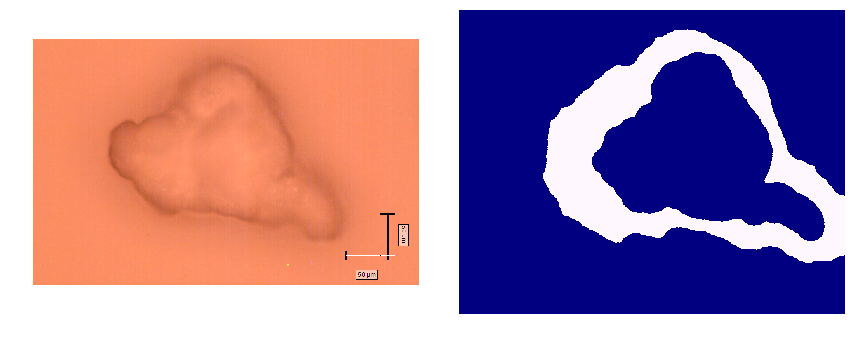

20190113 Samish Oyster 4b - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.94672362 0.43243383 0.6652185  0.82422027]
True label: irregular
Prediction: fiber


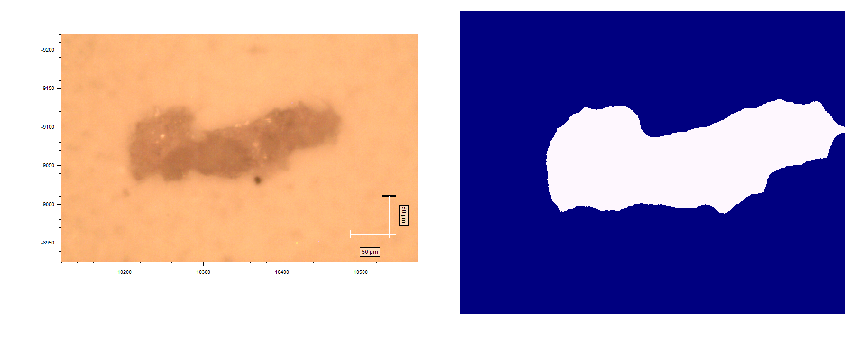

20190114 NBay Oyster 22a - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.85786    0.34613488 0.49220359 0.61859863]
True label: spheroid
Prediction: irregular


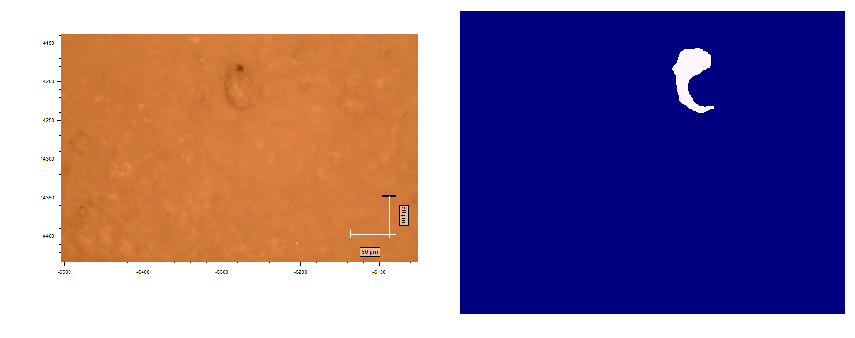

20190112 Heritage Oyster 20a - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.90708752 0.10352193 0.21860959 0.46245417]
True label: irregular
Prediction: fiber


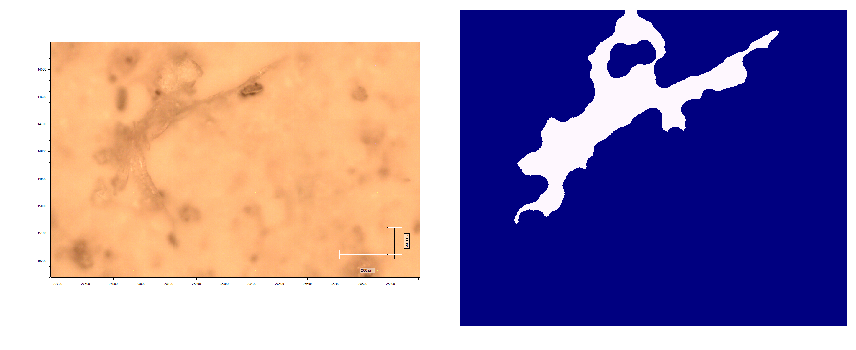

20191212 Set5Sample2_1 - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.45376165 0.69876476 0.68085106 0.90011481]
True label: spheroid
Prediction: shard


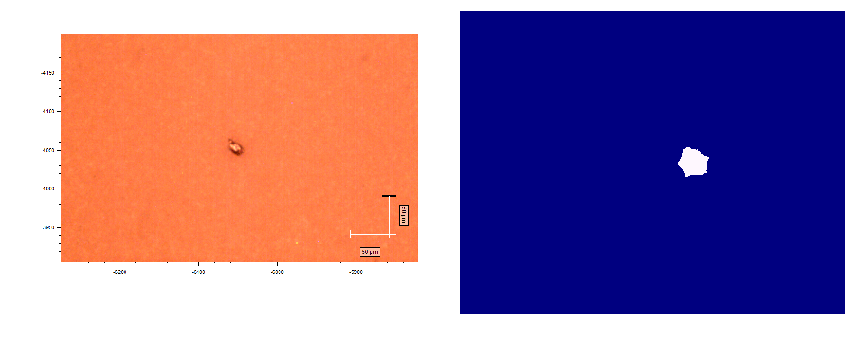

20190114 NBay Oyster 21b - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.88991677 0.22083016 0.2554095  0.51771725]
True label: shard
Prediction: irregular


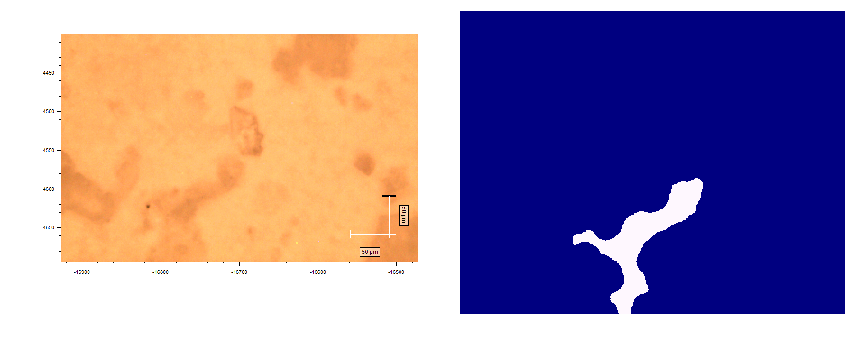

20191218 Set10Sample2_4 - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.96181702 0.39792767 0.72173489 0.82518457]
True label: shard
Prediction: fiber


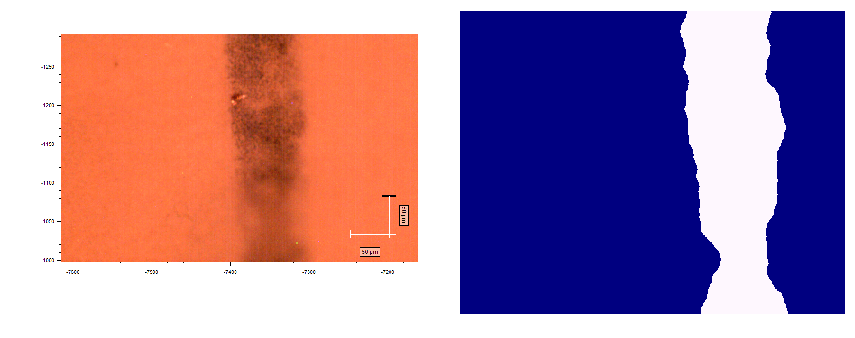

20190113 Penrose Pt Oyster 19a - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.96297387 0.34228345 0.48192593 0.70155953]
True label: irregular
Prediction: fiber


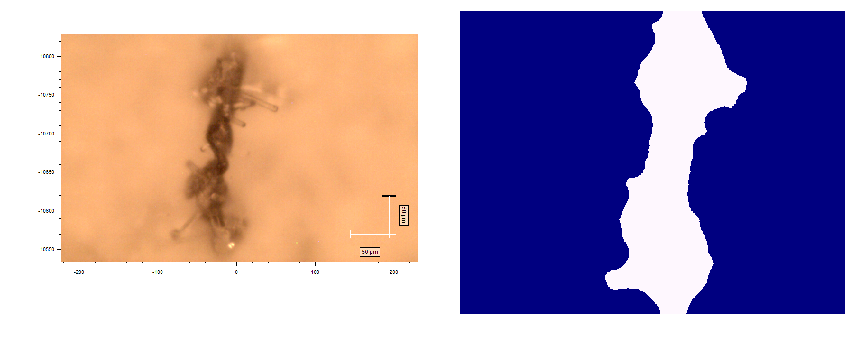

20200819 93_5 - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.76075958 0.56000219 0.57833384 0.81550234]
True label: irregular
Prediction: shard


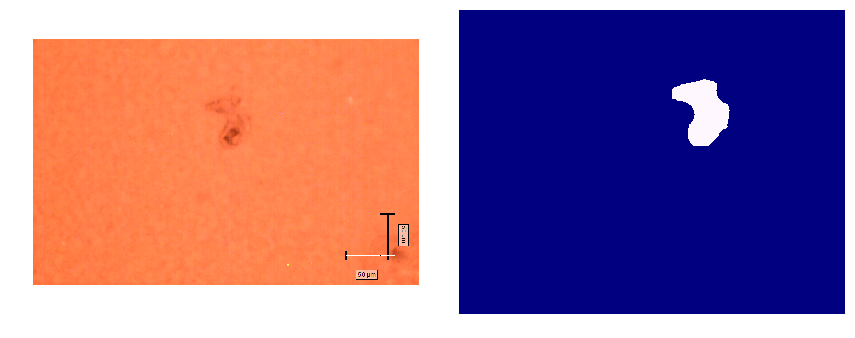

20210227 42.4 - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.6929294  0.14114664 0.38397626 0.53303674]
True label: shard
Prediction: irregular


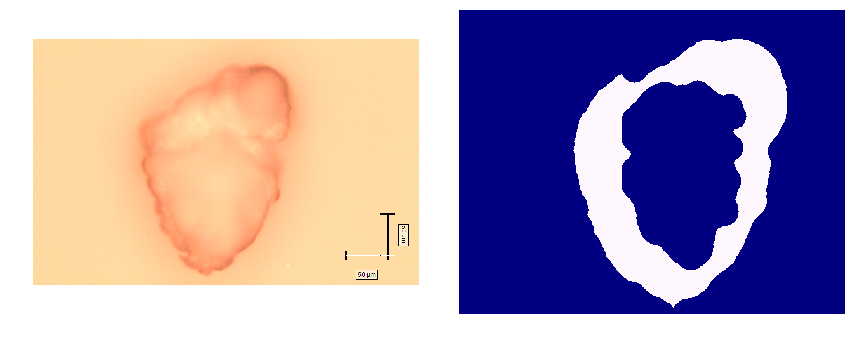

20210422 56.5 - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.72343289 0.16251854 0.45354797 0.55729035]
True label: spheroid
Prediction: irregular


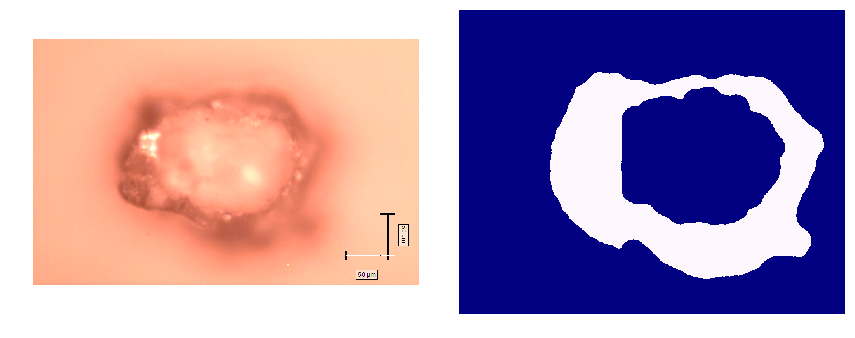

20201223 34.2 - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.47554259 0.14024618 0.37809424 0.4886214 ]
True label: spheroid
Prediction: irregular


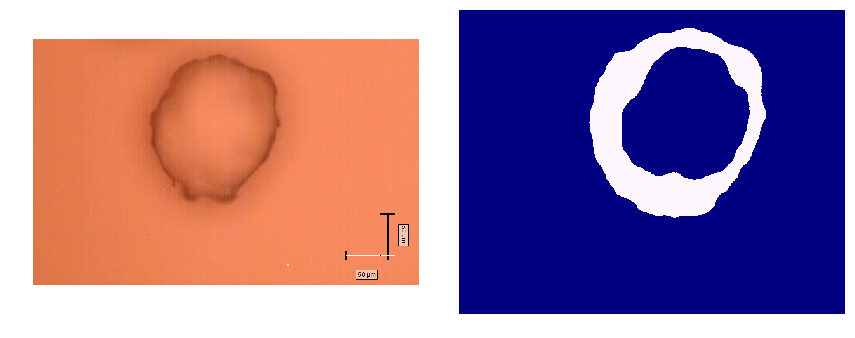

20190112 Heritage Oyster 21a - 10x.bmp
['eccentricity', 'compactness', 'extent', 'solidity']
[0.97208252 0.27105636 0.4667581  0.63529027]
True label: shard
Prediction: fiber


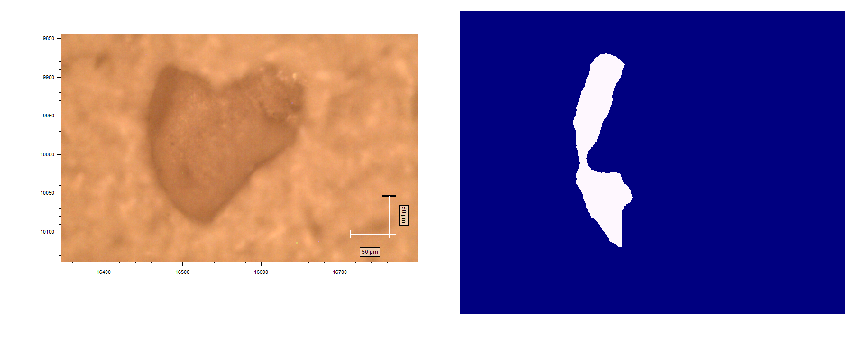

In [86]:
explore_results(X_test, Y_test, Z_test, indices_test)



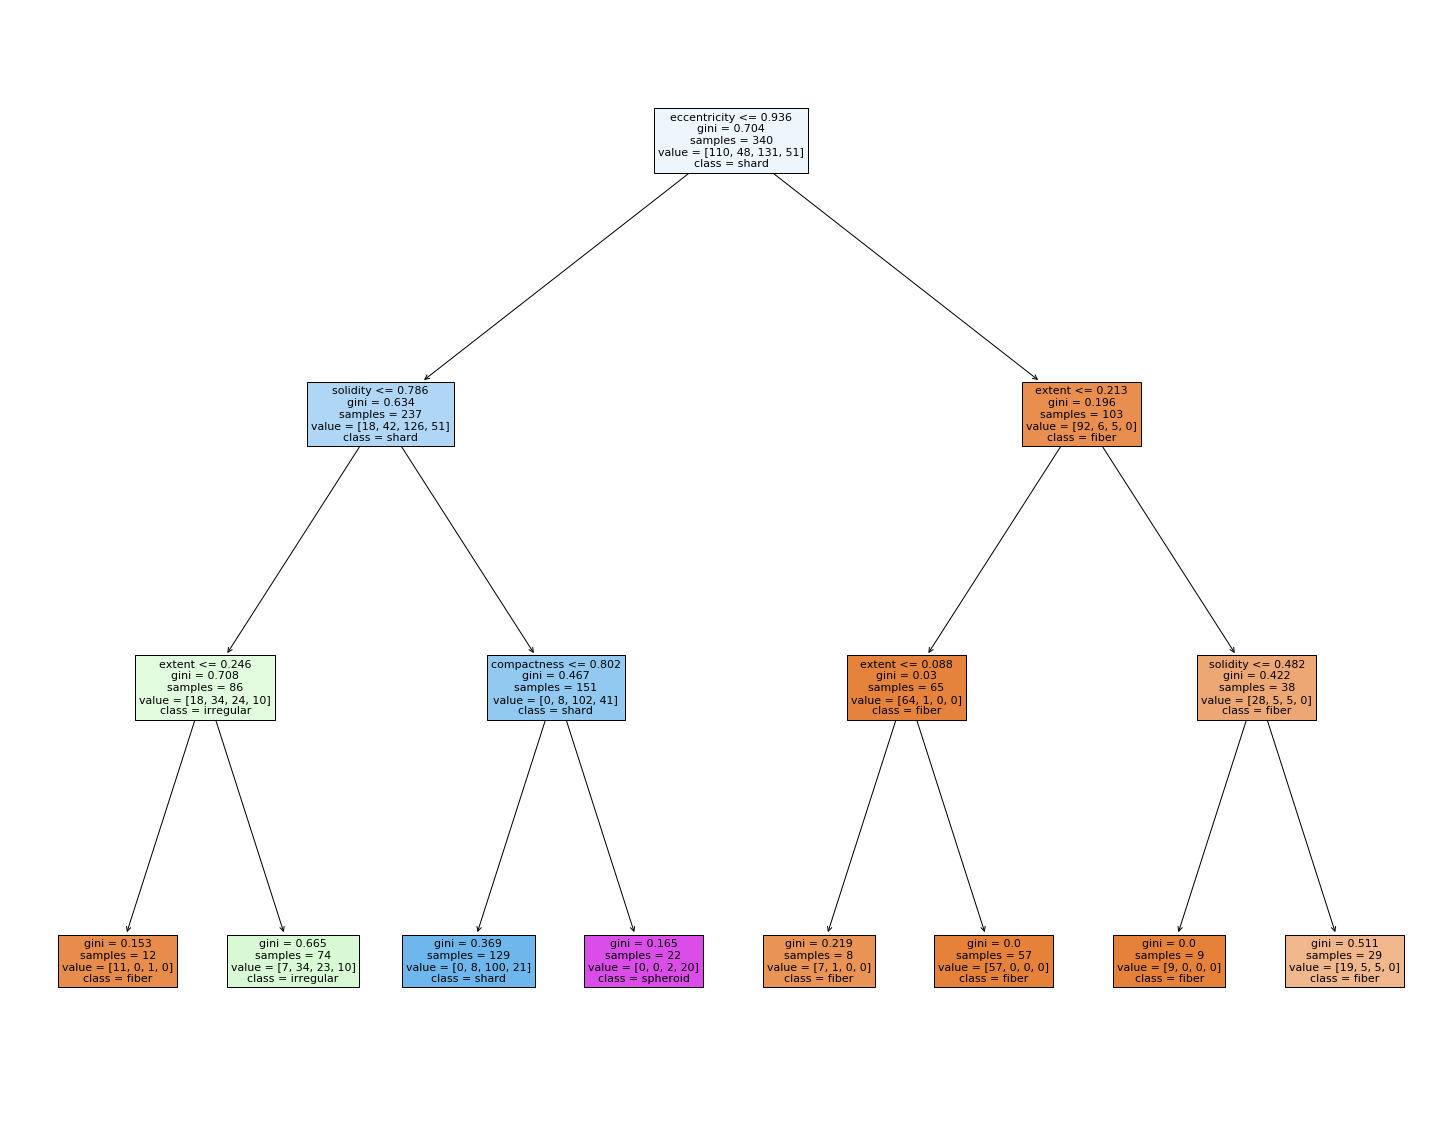

In [87]:
# Visualize tree
from sklearn import tree

fig = plt.figure(figsize=(25,20))
feature_cols = ["eccentricity", "compactness", "extent", "solidity"]

_ = tree.plot_tree(dtc, 
                   feature_names=feature_cols,  
                   class_names=dtc.classes_,
                   filled=True,
                   fontsize=11)
